In [1]:
#DBLP数据集频繁模式挖掘
import codecs
import itertools
import numpy as np
import networkx as nx
from xml.sax import handler, make_parser
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='c:/windows/fonts/simsun.ttc', size=14)

In [2]:
#数据获取：事先从网络上下载xml格式的DBLP数据集
DBLP_XML_PATH = 'D:/数据挖掘/作业二/dblp_dataset/dblp.xml' #数据集路径

In [3]:
#数据预处理
#此处需要完整添加所有“块”结构的标签，或者需要处理的类型的标签
paper_tag = ('article','inproceedings','proceedings','book',
             'incollection','phdthesis','mastersthesis','www')
#通过查看数据的总体情况可知，DBLP数据集中有论文的标题、作者和发表日期等属性。
#在本次实验中我们选取作者作为研究对象进行频繁模式挖掘，因此可以忽略标题和发表日期，
#这两项属性对于挖掘作者的频繁模式来说没有太大意义。
#只读取DBLP数据集中论文作者属性的值，具体代码如下所示：

In [4]:
#DBLP数据集论文作者属性值读取函数
class mHandler(handler.ContentHandler):

    def __init__(self,result):
        self.result = result
        self.flag = 0

    def startDocument(self):
        print('Document Start')

    def endDocument(self):
        print('Document End')

    def startElement(self, name, attrs):
        if name == 'author':
            self.flag = 1

    def endElement(self, name):
        if name == 'author':
            self.result.write(',')
            self.flag = 0
        if (name in paper_tag):
            self.result.write('\r\n')

    def characters(self, chrs):
        if self.flag:
            self.result.write(chrs)


def parserDblpXml(source,result):

    handler = mHandler(result)
    parser = make_parser()
    parser.setContentHandler(handler)

    parser.parse(source)

In [5]:
#从xml格式的DBLP数据集中读取论文作者属性的值并保存为txt格式文件
source = codecs.open(DBLP_XML_PATH, 'r', 'utf-8')
result = codecs.open('D:/数据挖掘/作业二/dblp_dataset/authors.txt', 'w', 'utf-8')
parserDblpXml(source,result)
result.close()
source.close()

Document Start
Document End


In [6]:
#频繁模式挖掘
#读取数据预处理得到的authors.txt文件，将其中独特的人名按照出现的次序顺序编码，
#并保存到authors_index.txt文件中
#根据编码将每篇论文的作者列表保存到authors_encoded.txt文件中
source = codecs.open('D:/数据挖掘/作业二/dblp_dataset/authors.txt', 'r', 'utf-8')
result = codecs.open('D:/数据挖掘/作业二/dblp_dataset/authors_encoded.txt', 'w', 'utf-8')
index = codecs.open('D:/数据挖掘/作业二/dblp_dataset/authors_index.txt', 'w', 'utf-8')
index_dic = {}
name_id = 0

for line in source:
    name_list = line.split(',')
    for name in name_list:
        if not (name == '\r\n'):
            if name in index_dic:
                index_dic[name][1] +=1
            else:
                index_dic[name] = [name_id,1]
                index.write(name + u'\r\n')
                name_id += 1
            result.write(str(index_dic[name][0]) + u',')
    result.write('\r\n')

source.close()
result.close()
index.close()

In [7]:
#查看数据的总体情况
#统计DBLP数据集中每位作者的支持度，并对支持度在40到200之间的作者情况进行可视化，
#具体代码和结果如下所示：

In [8]:
#支持度统计
data = codecs.open('D:/数据挖掘/作业二/dblp_dataset/authors_encoded.txt', 'r', 'utf-8')
word_counts = {}
maxCounts = 0
for line in data:
    line = line.split(',')
    for word in line[0:-1]:
        word_counts[word] = word_counts.get(word,0) + 1
        if word_counts[word] > maxCounts:
            maxCounts = word_counts[word]
            maxKey = word

xMax = maxCounts
data.close()
bins = {}
for k,v in word_counts.items():
    bins[v] = bins.get(v,0) + 1
y = []
for i in range(40, 200):
    y.append(bins.get(i,0))

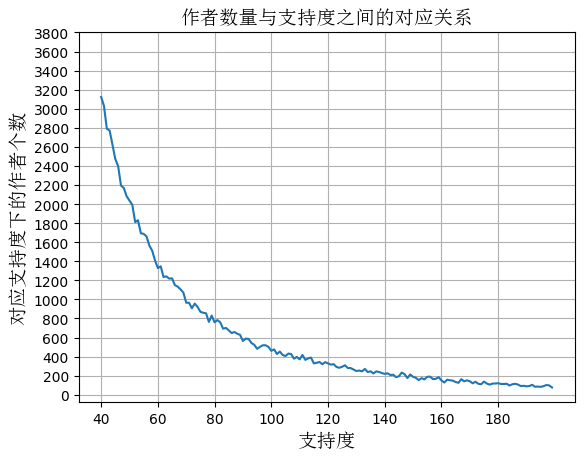

In [9]:
#统计结果可视化
plt.plot(y,'-');
plt.grid()
plt.yticks(range(0,4000,200))
plt.xticks(range(0,160,20),range(40,200,20))
plt.xlabel(u'支持度', fontproperties=font)
plt.ylabel(u'对应支持度下的作者个数', fontproperties=font)
plt.title(u'作者数量与支持度之间的对应关系', fontproperties=font)
plt.show()

In [10]:
#分析可视化结果可知，支持度为40的作者约有3200位，
#随后支持度每增加20，对应的作者数量减半
#为了在降低计算量的同时有一定数量的频繁模式挖掘结果，
#在进行论文作者的频繁模式挖掘时，支持度的阈值选为100

In [11]:
#构建FP-Tree并从FP-Tree得到频繁项集
#首先扫描数据库得到FP-Tree，然后再从树上递归生成条件模式树并上溯找到频繁项集，
#具体代码如下所示：
class treeNode:

    def __init__(self, nameValue, numOccur, parentNode):
        self.name = nameValue
        self.count = numOccur
        self.nodeLink = None
        self.parent = parentNode
        self.children = {}

    def inc(self, numOccur):
        self.count += numOccur


def createTree(dataSet, minSup=1):
    freqDic = {}

    for trans in dataSet:
        for item in trans:
            freqDic[item] = freqDic.get(item, 0) + dataSet[trans]  

    headerTable = {k:v for (k,v) in freqDic.items() if v >= minSup}
    if len(headerTable) == 0: return None, None
    for k in headerTable:
        headerTable[k] = [headerTable[k], None]

    retTree = treeNode('Null Set', 1, None)
    for tranSet, count in dataSet.items():
        localD = {}
        for item in tranSet:
            if headerTable.get(item,0):
                localD[item] = headerTable[item][0]
        if len(localD) > 0:
            orderedItems = [v[0] for v in sorted(localD.items(), key=lambda p: p[1], reverse=True)]
            updateTree(orderedItems, retTree, headerTable, count)

    return retTree, headerTable


def updateTree(items, inTree, headerTable, count):

    if items[0] in inTree.children:
        inTree.children[items[0]].inc(count)
    else:
        inTree.children[items[0]] = treeNode(items[0], count, inTree)
        if headerTable[items[0]][1] == None:
            headerTable[items[0]][1] = inTree.children[items[0]]
        else:
            updateHeader(headerTable[items[0]][1], inTree.children[items[0]])

    if len(items) > 1:
        updateTree(items[1::], inTree.children[items[0]], headerTable, count)


def updateHeader(nodeToTest, targetNode):
    while (nodeToTest.nodeLink != None):
        nodeToTest = nodeToTest.nodeLink
    nodeToTest.nodeLink = targetNode


def ascendTree(leafNode, prefixPath):
    if leafNode.parent != None:
        prefixPath.append(leafNode.name)
        ascendTree(leafNode.parent, prefixPath)

def findPrefixPath(basePat, treeNode):
    condPats = {}

    while treeNode != None:
        prefixPath = []
        ascendTree(treeNode, prefixPath)
        if len(prefixPath) > 1:
            condPats[frozenset(prefixPath[1:])] = treeNode.count
        treeNode = treeNode.nodeLink

    return condPats


def mineTree(inTree, headerTable, minSup, preFix, freqItemList):
    bigL = [v[0] for v in sorted(headerTable.items(), key=lambda p: p[1][0])]

    for basePat in bigL:
        newFreqSet = preFix.copy()
        newFreqSet.add(basePat)

        if len(newFreqSet) > 1:
            freqItemList[frozenset(newFreqSet)] = headerTable[basePat][0]
        condPattBases = findPrefixPath(basePat, headerTable[basePat][1])
        myCondTree, myHead = createTree(condPattBases, minSup)

        if myHead != None:
            mineTree(myCondTree, myHead, minSup, newFreqSet, freqItemList)


def loadSimpDat(inFile):
    dataSet = {}

    for line in inFile:
        line =line.strip().split(',')
        dataLine = [word for word in line if word.isdigit()]
        dataSet[frozenset(dataLine)] = dataSet.get(frozenset(dataLine),0) + 1

    return dataSet

In [12]:
#生成频繁项集查找结果
minSup = 100
print('Reading Source File ... Wait...')
with open('D:/数据挖掘/作业二/dblp_dataset/authors_encoded.txt', 'r') as f:
    dataSet = loadSimpDat(f)
print('Constructing FP-tree ... Wait...')
myFPtree, myHeaderTab = createTree(dataSet, minSup)
print('Mining frequent items ... Wait...')
myFreqList = {}
mineTree(myFPtree, myHeaderTab, minSup, set([]), myFreqList)
print('Totally {} frequent itemsets found!'.format(len(myFreqList)))
maxCoauthors = 0
for freqAuthors in myFreqList.keys():
    if len(freqAuthors) > maxCoauthors:
        maxCoauthors = len(freqAuthors)
print('the max num of coauthors is {}.'.format(maxCoauthors))

Reading Source File ... Wait...
Constructing FP-tree ... Wait...
Mining frequent items ... Wait...
Totally 1736 frequent itemsets found!
the max num of coauthors is 5.


In [13]:
#读取并建立作者编码索引
print('Constructing authors_index... Wait...')
with open('D:/数据挖掘/作业二/dblp_dataset/authors_index.txt', 'r') as authorsIndex:
    i = 0
    authorsDic = {}
    for name in authorsIndex:
        name = name.strip()
        authorsDic[i] = name
        i = i+1

#保存频繁项集查找结果
print('Writing result into result.txt... Wait...')
with open('D:/数据挖掘/作业二/dblp_dataset/result4.txt','w') as result2:
    with open('D:/数据挖掘/作业二/dblp_dataset/result3.txt','w') as result:
        result.write("%25s\t%25s\t%15s\t%10s\t%6s\t%6s\t%6s\t%6s\t%6s\t%6s\t%6s\t%6s\n" \
                   %('authorA','authorB','authorC','Sup(A,B,C)','Sup(A)','Sup(B)','Sup(C)',\
                     'Con(A)','Con(B)','Con(C)','MinCon','MaxCon'))
        result2.write("%25s\t%25s\t%15s\t%10s\t%6s\t%6s\t%6s\t%6s\t%6s\t%6s\t%6s\t%6s\n" \
                    %('authorA','authorB','authorC','Sup(A,B,C)','Sup(A)','Sup(B)','Sup(C)',\
                      'Con(A)','Con(B)','Con(C)','MinCon','MaxCon'))
        resultList = sorted(myFreqList.items(), key=lambda p: p[1], reverse=True)
        for itemSet, support in resultList:
            itemList = list(itemSet)
            A = itemList[0]
            authorA = authorsDic.get(int(A),'0')
            B = itemList[1]
            authorB = authorsDic.get(int(B),'0')
            SupAB_C = int(support)
            SupA = int(myHeaderTab.get(A,[0])[0])
            SupB = int(myHeaderTab.get(B,[0])[0])
            ConA = float(SupAB_C) / float(SupA)
            ConB = float(SupAB_C) / float(SupB)
            (C,authorC,SupC,ConC) = ('','',0.0,0.0)

            if len(itemList) == 3:
                C = itemList[2]
                authorC = authorsDic.get(int(C),'0')
                SupC = int(myHeaderTab.get(C,[0])[0])
                ConC = float(SupAB_C) / float(SupC)
                MinCon = min([ConA, ConB, ConC])
                MaxCon = max([ConA, ConB, ConC])
            elif len(itemList) == 2:
                MinCon = min([ConA, ConB])
                MaxCon = max([ConA, ConB])                

            if MinCon < 0.4 or MaxCon < 0.5 or (MinCon + MaxCon)/2 < 0.5:
                continue
            result.write("%25s\t%25s\t%15s\t%10.0f\t%6.0f\t%6.0f\t%6.0f\t%6.4f\t%6.4f\t%6.4f\t%6.4f\t%6.4f\n" \
                       %(authorA,authorB,authorC,SupAB_C,\
                         SupA,SupB,SupC,ConA,ConB,ConC,MinCon,MaxCon))
            result2.write("%25s\t%25s\t%15s\t%10.0f\t%6.0f\t%6.0f\t%6.0f\t\%6.4f\t%6.4f\t%6.4f\t%6.4f\t%6.4f\n"\
                        %(A,B,C,SupAB_C,SupA,SupB,SupC,\
                          ConA,ConB,ConC,MinCon,MaxCon))
print('Finished!')

Constructing authors_index... Wait...
Writing result into result.txt... Wait...
Finished!


In [14]:
#频繁项集查找结果被保存在代码仓库中
#分析频繁项集查找结果可以发现：
#1、作者之间存在着一定的合作关系
#2、在满足支持度的作者中，大多数人是2人合作，但也有少数3个人一起经常合作的情况
#3、合作关系是双向的，因此可以直接考虑置信度
#在按发表论文数量排序后，某些作者的置信度较低，需要引入置信度阈值
#为了避免置信度不平衡的情况，加入阈值条件MinCon > 0.4，
#同时置信度中的较大值应该满足MaxCon > 0.5，
#另外加入平衡条件(MinCon + MaxCon)/2 > 0.5
#根据分析结果，可将这种频繁模式命名为：论文-作者网络中的合作模式

In [15]:
#以Irith Pomeranz为例进行可视化展示
def createEdge(nodeX):
    with codecs.open('D:/数据挖掘/作业二/dblp_dataset/authors.txt', 'r', 'utf-8') as f:
        for line in f:
            line = line.strip().split(',')
            if line[-1] == '':
                line.remove('')
            if nodeX in line and len(line) >1:
                line.remove(nodeX)
                for author in line:
                    yield (author,nodeX)


def makeFreqDic():
    print('Creating FreqDic...')
    with codecs.open('D:/数据挖掘/作业二/dblp_dataset/authors.txt', 'r', 'utf-8') as f:
        freqDic = {}
        for line in f:           
            line = line.strip().split(',')
            if line[-1] == '':
                line.remove('')               
            for author in line:
                freqDic[author] = freqDic.get(author,0) + 1
        return freqDic


def draw(freqDic,nodeX):
    G = nx.Graph()
    print('Adding edge...')
    for A,B in createEdge(nodeX):
        edgeDic = G.get_edge_data(A,B,default = {'weight':0})
        G.add_edge(A, B, weight = edgeDic['weight'] + 1)
    nodes = G.nodes()
    list(nodes).remove(nodeX)
    shells = [[nodeX], nodes]
    pos = nx.shell_layout(G,shells)
    print('Drawing nodes...')
    nodeSize = [10*freqDic[n] for n, dic in list(G.nodes(data=True))]
    nodeColors = np.random.rand(len(nodeSize))
    nx.draw_networkx_nodes(G, pos, node_size=nodeSize,node_color= nodeColors,alpha=0.7)
    print('Drawing edges...')
    edgeWidth = [edata['weight']/2 for u,v,edata in G.edges(data=True)]
    edgeColor = np.random.rand(G.number_of_edges())
    nx.draw_networkx_edges(G, pos, width = edgeWidth, edge_color=edgeColor,alpha=0.35)
    print('Adding label...')
    select_labels = {n:n for n,d in list(G.nodes(data=True)) if freqDic[n] >= 80}
    select_labels[nodeX]= nodeX
    nx.draw_networkx_labels(G,pos,labels = select_labels,font_size=8,alpha=0.3)
    title = str(nodeX) + u"与其合作者之间的关系网络"
    plt.title(title, size=15,fontproperties=font)
    plt.text(0.5, 0.94,  u"# 节点大小对应该作者发表文章总次数",
             horizontalalignment='center',
             size=10,color='r',verticalalignment='center',
             transform=plt.gca().transAxes,
             fontproperties=font)
    plt.text(0.5, 0.97,  u"# 节点之间连线粗细对应该两个作者一起发表文章总次数",
             horizontalalignment='center',
             size=10,color='r',verticalalignment='center',
             transform=plt.gca().transAxes,
             fontproperties=font)
    plt.axis('off')
    fileName = str(nodeX) + ".png"
    plt.savefig(fileName,transparent=True,dpi=500)
    plt.show()

Creating FreqDic...
Adding edge...
Drawing nodes...
Drawing edges...
Adding label...


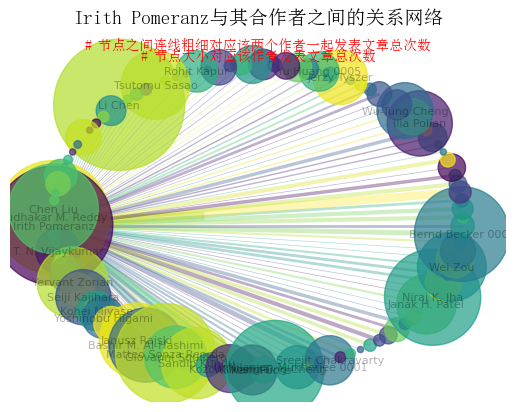

In [16]:
freqDic = makeFreqDic()
nodeX = u'Irith Pomeranz'
draw(freqDic, nodeX)

In [17]:
#SNAP数据集中MOOC用户操作数据集的频繁模式挖掘
import pandas as pd
import pyfpgrowth

In [18]:
#数据获取：事先从网络上下载tsv格式的MOOC用户操作数据集
MOOC_TSV_PATH = 'D:/数据挖掘/作业二/act-mooc/' #数据集路径

In [19]:
#数据预处理
#读取数据
actions = pd.read_csv(MOOC_TSV_PATH + 'mooc_actions.tsv', delimiter='\t')
features = pd.read_csv(MOOC_TSV_PATH + 'mooc_action_features.tsv', delimiter='\t')
labels = pd.read_csv(MOOC_TSV_PATH + 'mooc_action_labels.tsv', delimiter='\t')

#数据清洗：检查是否存在缺失值
print('Cleaning actions data - dropping missing values.')
actions = actions.dropna()
print('Cleaning features data - dropping missing values.')
features = features.dropna()
print('Cleaning labels data - dropping missing values.')
labels = labels.dropna()

#数据整合：按action字段将三个文件整合成一个文件
actions_with_features = pd.merge(actions, features, on='ACTIONID')
actions_with_features_labels = pd.merge(actions_with_features, labels, on='ACTIONID')

#按action字段对数据进行排序
actions_with_features_labels = actions_with_features_labels.sort_values(by='ACTIONID')
actions_with_features_labels.to_csv(MOOC_TSV_PATH + 'mooc_actions_data.csv', index=False) #保存数据集

Cleaning actions data - dropping missing values.
Cleaning features data - dropping missing values.
Cleaning labels data - dropping missing values.


In [20]:
#将数据集结构转换为图结构
def convert_to_graph(filename):

    #读取数据集文件
    df = pd.read_csv(filename)

    #创建空图
    G = nx.DiGraph()

    #添加节点
    G.add_nodes_from(df['USERID'], type='user')
    G.add_nodes_from(df['TARGETID'], type='target')

    #添加带有属性的边
    for _, row in df.iterrows():
        edge_attrs = {
            'timestamp': row['TIMESTAMP'],
            'feature0': row['FEATURE0'],
            'feature1': row['FEATURE1'],
            'feature2': row['FEATURE2'],
            'feature3': row['FEATURE3'],
            'label':row['LABEL']
        }
        G.add_edge(row['USERID'], row['TARGETID'], **edge_attrs)

    return G

In [21]:
data_graph = convert_to_graph(MOOC_TSV_PATH + 'mooc_actions_data.csv')
print('数据集图信息：')
print(data_graph)

数据集图信息：
DiGraph with 7047 nodes and 174870 edges


In [22]:
#频繁模式挖掘
transactions = []

#逐块读取并处理数据
reader = pd.read_csv(MOOC_TSV_PATH + 'mooc_actions_data.csv', chunksize=10000)

for chunk in reader:
    #提取USERID和TARGETID作为项集
    items = chunk[['USERID', 'TARGETID']]
    
    for _, group in items.groupby('USERID'):
        transactions.append(list(group['TARGETID'].unique()))

#使用pyfpgrowth库构建FP-Tree并从FP-Tree得到频繁项集
patterns = pyfpgrowth.find_frequent_patterns(transactions, len(transactions) * 0.05)
rules = pyfpgrowth.generate_association_rules(patterns, 0.1)

#按照支持度对频繁项集进行排序并输出
sorted_freq_itemsets = sorted(patterns.items(), key=lambda x: x[1], reverse=True)
print('频繁项集：')
for itemset, support_count in sorted_freq_itemsets:
    print('{}: {}'.format(itemset, support_count))

#按照置信度对关联规则进行排序并输出
sorted_rules = sorted(rules.items(), key=lambda item: item[1][1], reverse=True)
print('关联规则：')
for antecedent, (consequent, confidence) in sorted_rules:
    print('{} => {}: {}'.format(antecedent, consequent, confidence))

频繁项集：
(8,): 12233
(3,): 8743
(12,): 7026
(1, 3): 5844
(3, 13): 5408
(3, 4): 5173
(7, 8): 5105
(7, 9): 5007
(7, 14): 4870
(4, 5): 4661
(23,): 4573
(8, 9): 4353
(4, 15): 4179
(3, 5): 3982
(1, 4): 3980
(9, 14): 3843
(5, 16): 3841
(1, 13): 3833
(21,): 3831
(1, 3, 13): 3815
(5, 6): 3767
(3, 8): 3755
(4, 8): 3754
(36,): 3752
(6, 17): 3704
(1, 3, 4): 3650
(7, 9, 14): 3647
(3, 15): 3611
(3, 4, 5): 3564
(3, 7): 3446
(7, 17): 3442
(25, 26): 3364
(22, 32): 3317
(1, 2): 3306
(1, 7): 3230
(3, 13, 15): 3228
(7, 8, 9): 3224
(25, 27): 3203
(4, 6): 3187
(37,): 3177
(3, 4, 13): 3150
(7, 8, 14): 3130
(15, 16): 3103
(3, 4, 15): 3100
(12, 22): 2938
(5, 6, 17): 2918
(26, 28): 2899
(4, 5, 6): 2896
(6, 18): 2865
(17, 19): 2850
(8, 25): 2837
(4, 13, 15): 2804
(7, 14, 17): 2794
(25, 28): 2786
(4, 5, 16): 2751
(1, 3, 5): 2748
(6, 7, 17): 2719
(3, 4, 13, 15): 2718
(4, 5, 15): 2717
(1, 8): 2684
(4, 5, 8): 2676
(7, 9, 17): 2672
(4, 15, 16): 2656
(2, 3): 2651
(1, 4, 5): 2648
(16, 18): 2641
(5, 15, 16): 2637
(3, 4, 8

In [23]:
#分析频繁项集查找结果可以发现：
#1、某些TARGETID的出现频繁，
#这表明与其相关的课程资源经常被用户操作
#2、某些TARGETID的组合出现频繁，
#这表明用户经常在操作了某个TARGETID之后操作另一个特定的TARGETID
#3、频繁项集的支持度说明哪些TARGETID或TARGETID的组合在用户操作中更为常见。
#该结果可被用于系统推荐，例如，推荐那些经常被一起操作的课程资源
#分析关联规则查找结果可以发现：
#1、可以依据结果推断用户的操作习惯，
#某个强规则表明用户在操作了某些TARGETID之后，
#通常会操作另一个特定的TARGETID
#2、关联规则的查找结果可被用于个性化推荐，
#例如，根据用户的前几个操作推荐他们可能的下一个操作
#根据分析结果，可将这种频繁模式命名为：用户-目标活动模式

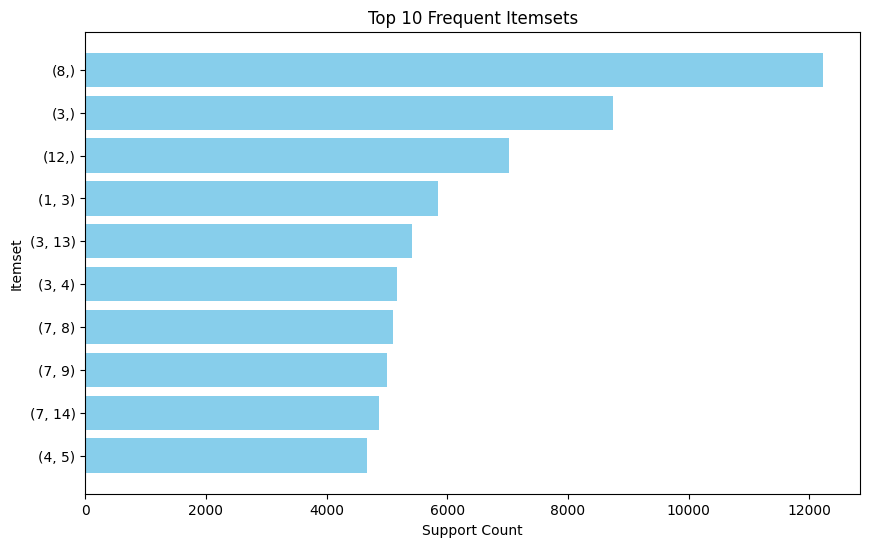

In [24]:
#可视化展示
#频繁项集可视化
plt.figure(figsize=(10, 6))
plt.barh([str(itemset) for itemset, _ in sorted_freq_itemsets[:10]], [support_count for _, \
          support_count in sorted_freq_itemsets[:10]], color='skyblue')
plt.xlabel('Support Count')
plt.ylabel('Itemset')
plt.title('Top 10 Frequent Itemsets')
plt.gca().invert_yaxis()
plt.show()

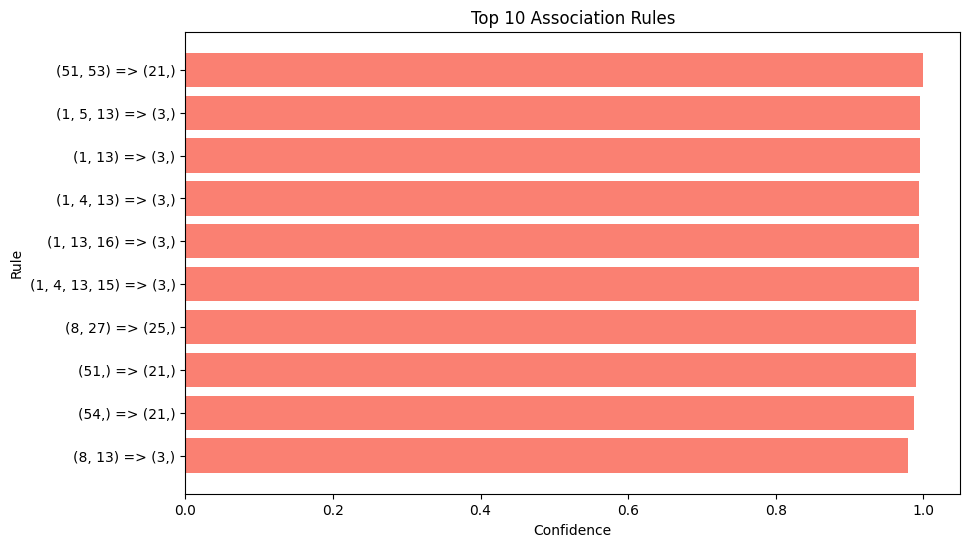

In [25]:
#关联规则可视化
plt.figure(figsize=(10, 6))
plt.barh([f"{antecedent} => {consequent}" for antecedent, (consequent, confidence) in sorted_rules[:10]], \
          [confidence for _, (consequent, confidence) in sorted_rules[:10]], color='salmon')
plt.xlabel('Confidence')
plt.ylabel('Rule')
plt.title('Top 10 Association Rules')
plt.gca().invert_yaxis()
plt.show()